In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:

def forward(nlay, res, thi, ndat, per):
    """
    Cálculo do MT 1D pela metodologia do Grandis (1999).
    
    Parâmetros:
    nlay : int
        Número de camadas
    res : array_like
        Resistividade de cada camada (Ohm.m), tamanho (nlay)
    thi : array_like
        Espessura de cada camada (metros), tamanho (nlay)
    ndat : int
        Número de períodos
    per : array_like
        Períodos (s), tamanho (ndat)
    
    Retorna:
    zre : array_like
        Parte real da impedância calculada (V/A)
    zim : array_like
        Parte imaginária da impedância calculada (V/A)
    """
    pi = np.pi
    amu = pi * 4.0e-7

    zre = np.zeros(ndat)
    zim = np.zeros(ndat)

    for i in range(ndat):
        # Inicialização
        zint = np.zeros(nlay, dtype=complex)
        tran = np.zeros((2, 2, nlay), dtype=complex)

        # Montagem das matrizes de transferência
        for j in range(nlay):
            z = np.sqrt(pi * amu * res[j] / per[i])
            zint[j] = complex(z, z)
            expo = np.exp(-2.0 * zint[j] / res[j] * thi[j])
            expl = (1.0 + 0.0j) + expo
            exp2 = (1.0 + 0.0j) - expo
            tran[0, 0, j] = expl
            tran[0, 1, j] = zint[j] * exp2
            tran[1, 0, j] = exp2 / zint[j]
            tran[1, 1, j] = expl

        # Matriz identidade
        a = np.array([[1.0 + 0.0j, 0.0 + 0.0j],
                      [0.0 + 0.0j, 1.0 + 0.0j]], dtype=complex)

        # Recorrência: multiplicação das matrizes
        for k in range(nlay - 1):
            b = np.matmul(a, tran[:, :, k])
            a = b.copy()

        # Cálculo da impedância
        rnom = zint[-1] * b[0, 0] + b[0, 1]
        rden = zint[-1] * b[1, 0] + b[1, 1]

        z = rnom / rden
        zre[i] = np.real(z)
        zim[i] = np.imag(z)

    return zre, zim


In [15]:

# Modelo de 3 camadas
res = np.array([100, 200, 1000])  # Resistividades (Ohm.m)
thi = np.array([500,100, np.inf])   # Espessuras (m)

nlay = len(res)

# Definição dos períodos
per = np.logspace(-3, 3, 40)  # de 0.001 s a 1000 s
ndat = len(per)

# Chamada da função forward
zre, zim = forward(nlay, res, thi, ndat, per)


In [6]:
type(per)

numpy.ndarray

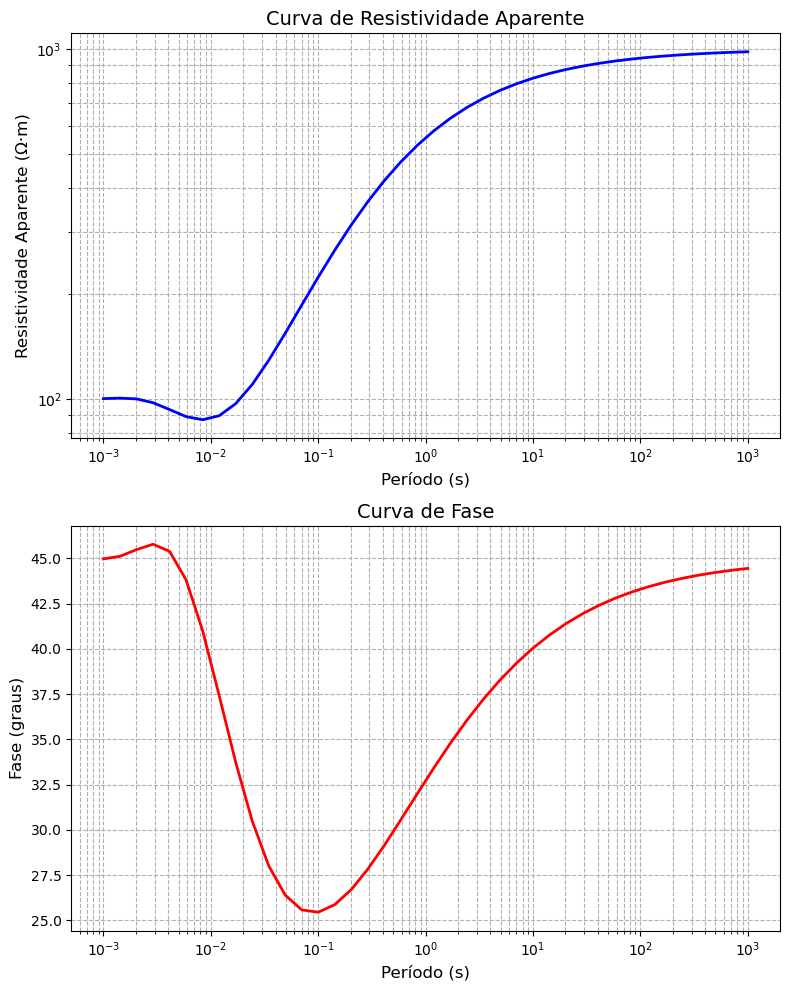

In [16]:
# --- PLOTA DIRETO ---

# Constantes
mu0 = 4 * np.pi * 1e-7
omega = 2 * np.pi / per

# Calcula resistividade aparente e fase
z = zre + 1j * zim
rhoa = (np.abs(z)**2) / (mu0 * omega)
phase = np.arctan2(zim, zre) * 180 / np.pi

# Faz os gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Resistividade aparente
ax1.loglog(per, rhoa, 'b', linewidth=2)
ax1.set_xlabel('Período (s)', fontsize=12)
ax1.set_ylabel('Resistividade Aparente (Ω·m)', fontsize=12)
ax1.grid(True, which='both', ls='--')
ax1.set_title('Curva de Resistividade Aparente', fontsize=14)

# Fase
ax2.semilogx(per, phase, 'r', linewidth=2)
ax2.set_xlabel('Período (s)', fontsize=12)
ax2.set_ylabel('Fase (graus)', fontsize=12)
ax2.grid(True, which='both', ls='--')
ax2.set_title('Curva de Fase', fontsize=14)

plt.tight_layout()
plt.show()

## Com o vetor de espessuras menor

In [12]:
def forward(res, thi, per):
    """
    Cálculo MT 1D versão limpa: 
    - res: resistividades (Ohm.m) [N camadas]
    - thi: espessuras (m) [N-1 camadas]
    - per: períodos (s)
    """
    nlay = len(res)
    ndat = len(per)

    pi = np.pi
    amu = pi * 4.0e-7

    zre = np.zeros(ndat)
    zim = np.zeros(ndat)

    for i in range(ndat):
        zint = np.zeros(nlay, dtype=complex)
        tran = np.zeros((2, 2, nlay-1), dtype=complex)

        for j in range(nlay):
            z = np.sqrt(pi * amu * res[j] / per[i])
            zint[j] = complex(z, z)
        
        for j in range(nlay-1):
            expo = np.exp(-2.0 * zint[j] / res[j] * thi[j])
            expl = (1.0 + 0.0j) + expo
            exp2 = (1.0 + 0.0j) - expo
            tran[0, 0, j] = expl
            tran[0, 1, j] = zint[j] * exp2
            tran[1, 0, j] = exp2 / zint[j]
            tran[1, 1, j] = expl

        a = np.array([[1.0 + 0.0j, 0.0 + 0.0j],
                      [0.0 + 0.0j, 1.0 + 0.0j]], dtype=complex)

        for k in range(nlay - 1):
            a = np.matmul(a, tran[:, :, k])

        rnom = zint[-1] * a[0, 0] + a[0, 1]
        rden = zint[-1] * a[1, 0] + a[1, 1]

        z = rnom / rden
        zre[i] = np.real(z)
        zim[i] = np.imag(z)

    return zre, zim


In [13]:

# Modelo de 3 camadas
res = np.array([100, 200, 1000])  # Resistividades (Ohm.m)
thi = np.array([500,100])   # Espessuras (m)

nlay = len(res)

# Definição dos períodos
per = np.logspace(-3, 3, 40)  # de 0.001 s a 1000 s
ndat = len(per)

# Chamada da função forward
zre, zim = forward(nlay, res, thi, ndat, per)


TypeError: forward() takes 3 positional arguments but 5 were given

In [ ]:
# --- PLOTA DIRETO ---

# Constantes
mu0 = 4 * np.pi * 1e-7
omega = 2 * np.pi / per

# Calcula resistividade aparente e fase
z = zre + 1j * zim
rhoa = (np.abs(z)**2) / (mu0 * omega)
phase = np.arctan2(zim, zre) * 180 / np.pi

# Faz os gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Resistividade aparente
ax1.loglog(per, rhoa, 'b', linewidth=2)
ax1.set_xlabel('Período (s)', fontsize=12)
ax1.set_ylabel('Resistividade Aparente (Ω·m)', fontsize=12)
ax1.grid(True, which='both', ls='--')
ax1.set_title('Curva de Resistividade Aparente', fontsize=14)

# Fase
ax2.semilogx(per, phase, 'r', linewidth=2)
ax2.set_xlabel('Período (s)', fontsize=12)
ax2.set_ylabel('Fase (graus)', fontsize=12)
ax2.grid(True, which='both', ls='--')
ax2.set_title('Curva de Fase', fontsize=14)

plt.tight_layout()
plt.show()